# Text Classification for Sentiment Analysis

## Large Movie Review Dataset
"This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details."

Source: http://ai.stanford.edu/~amaas/data/sentiment/

This notebook was inspired by: 

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671


## Initial Imports

In [ ]:
# Initial packages
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Download the data from Stanford's directory
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname = "aclImdb_v1.tar.gz", 
                                  origin = URL,
                                  untar = True,
                                  cache_dir = '.',
                                  cache_subdir = '')

# Remove unlabelled reviews
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')

# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

# View the final train folder
print(os.listdir(train_dir))

84140032/84125825 [==============================] - 4s 0us/step
['urls_unsup.txt', 'unsupBow.feat', 'urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat', 'neg', 'pos']


### Train & Test Split

Now that we have our data cleaned and prepared, we can create `text_dataset_from_directory` with the following lines. We want to process the entire data in a single batch which is why we have selected a very large batch size.

In [ ]:
# Creating a training + validation dataset with a 80/20 split according to paper
# Source: https://arxiv.org/pdf/1905.05583.pdf
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size = 30000, validation_split = 0.2, 
    subset = 'training', seed = 123)

validation = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', batch_size = 30000, validation_split = 0.2, 
    subset = 'validation', seed = 123)

test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', batch_size = 30000, seed = 123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Convert to Pandas to View and Process

Now that we have our basic train and test datasets, we want to prepare them for the models to be used. For that matter, we are going to create a pandas dataframe from our TensorFlow dataset object for easier pre-processing.

In [ ]:
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
# Training set
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['Text', 'Label']
train['Text'] = train['Text'].str.decode("utf-8")
train.head()

,Text,Label
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [ ]:
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
# Validation set
for j in validation.take(1):
  validation_feat = j[0].numpy()
  validation_lab = j[1].numpy()

validation = pd.DataFrame([validation_feat, validation_lab]).T
validation.columns = ['Text', 'Label']
validation['Text'] = validation['Text'].str.decode("utf-8")
validation.head()

,Text,Label
0,I couldn't relate to this film. I'm surprised ...,0
1,I bought this video on a throw-out table at th...,0
2,I first read about the Left Behind series a fe...,0
3,"If there were an EPA for film, then this movie...",0
4,Chicago reporter Frank Quinlan decided to go t...,1


In [ ]:
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
# Test set
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['Text', 'Label']
test['Text'] = test['Text'].str.decode("utf-8")
test.head()

,Text,Label
0,"A lovely librarian, played by Playboy model Kr...",1
1,I suffered the watching of this movie at Sitge...,0
2,"It may not have had the big budgets, celebriti...",1
3,This early film from future goremeister Lucio ...,1
4,I didn't see this movie until it appeared on t...,1


## Exploring the data set

### Checking if data set is balanced...

In [ ]:
# Concatenate the two data sets
df = pd.concat([train, validation, test], ignore_index = True)
#df.loc[0]

# Check if data set is balanced
print(df['Label'].value_counts())

1    25000
0    25000
Name: Label, dtype: int64


In [ ]:
# Check word + character length
print('Average word length of reviews: {0:.0f}'.format(np.mean(df['Text'].apply(lambda x: len(x.split())))))
print('Max word length of reviews: {0:.0f}'.format(np.max(df['Text'].apply(lambda x: len(x.split())))))
print('Average character length of reviews: {0:.0f}'.format(np.mean(df['Text'].apply(lambda x: len(x)))))

Average word length of reviews: 230
Max word length of reviews: 2470
Average character length of reviews: 1305


### Visualize the classes

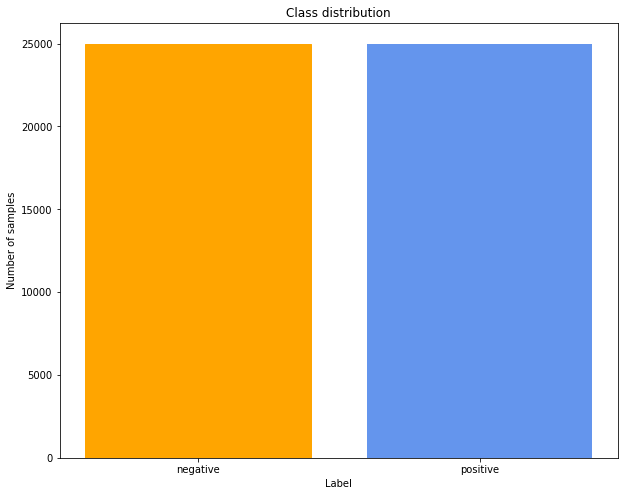

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10.0, 8.0)
barplot = plt.bar([0, 1], [df['Label'].value_counts()[0], df['Label'].value_counts()[1]], 
                  width = 0.8, color = 'cornflowerblue')
barplot[0].set_color('orange')
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(range(2), ['negative', 'positive']) 
plt.show()

### Checking for most common words in the data set

In [ ]:
 # Convert data frame to numPy array for hassle-free use in the following 
 # functions
 df_arr = np.asarray(df['Text'])

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range = (1, 1),
                                          num_ngrams = 50):
    """
    Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.

    # Returns:
       Top `num_ngrams` frequent n-grams will be plotted.

    # Source: https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # indices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary
    all_ngrams = list(vectorizer.get_feature_names_out())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    
    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis = 0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse = True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.rcParams["figure.figsize"] = (20.0, 10.0)
    plt.bar(idx, counts, width = 0.8, color = 'cornflowerblue')
    plt.xlabel('bigrams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of bigrams')
    plt.xticks(idx, ngrams, rotation = 45)
    plt.show()

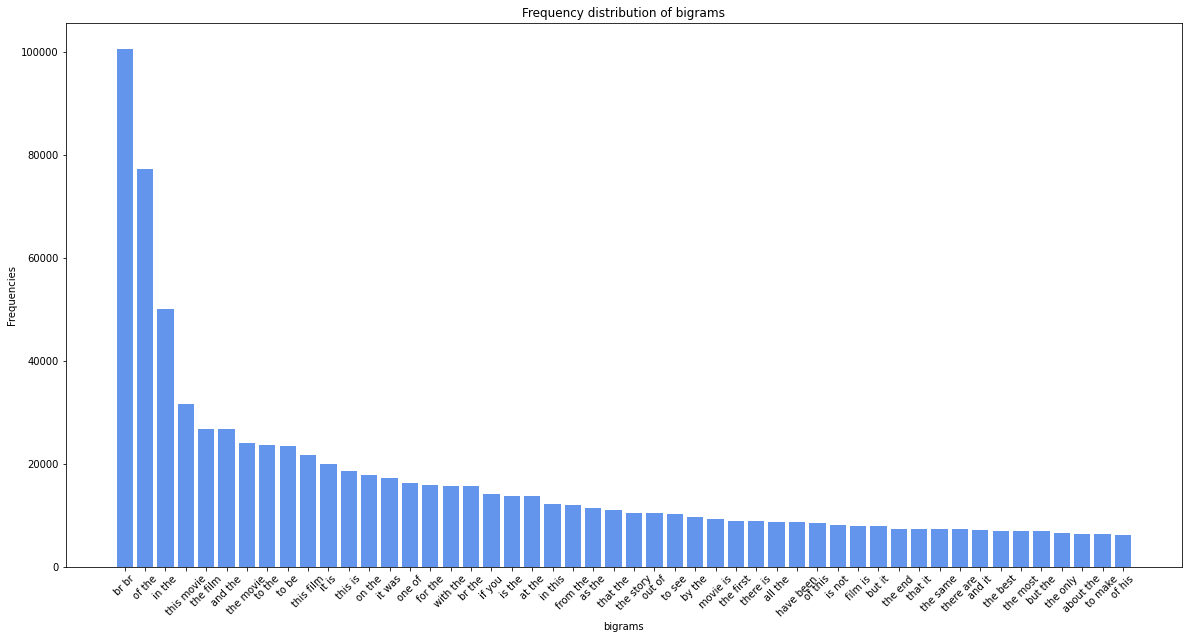

In [ ]:
plot_frequency_distribution_of_ngrams(df_arr, ngram_range = (2, 2))

### Checking the distribution of the Reviews (Positive & Negative)

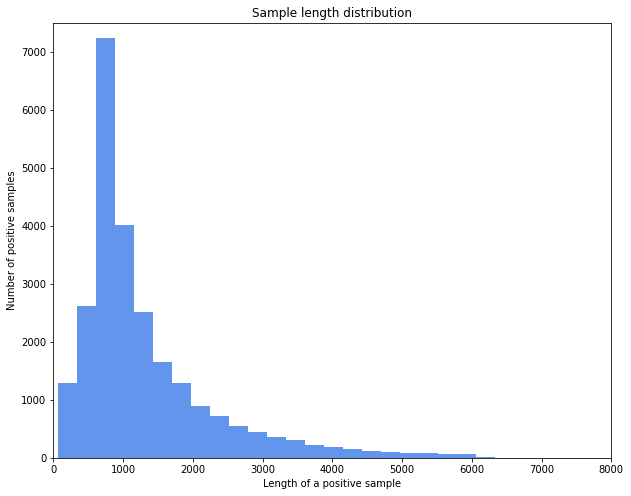

In [ ]:
# Categorizing into positive + negative
pos = df[df['Label'] == 1]['Text']
neg = df[df['Label'] == 0]['Text']

# Checking the distribution of positive reviews
def plot_sample_length_distribution(sample_texts):
    """
    Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.

    # Returns
        Plots the length i.e. how many characters each sample has

    # Source: https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
    """
    
    plt.rcParams["figure.figsize"] = (10.0, 8.0)
    plt.hist([len(s) for s in sample_texts], 50, color = 'cornflowerblue')
    plt.xlabel('Length of a positive sample')
    plt.ylabel('Number of positive samples')
    plt.xlim(0, 8000)
    plt.ylim(0, 7500)
    plt.title('Sample length distribution')
    plt.show()
  
plot_sample_length_distribution(pos)

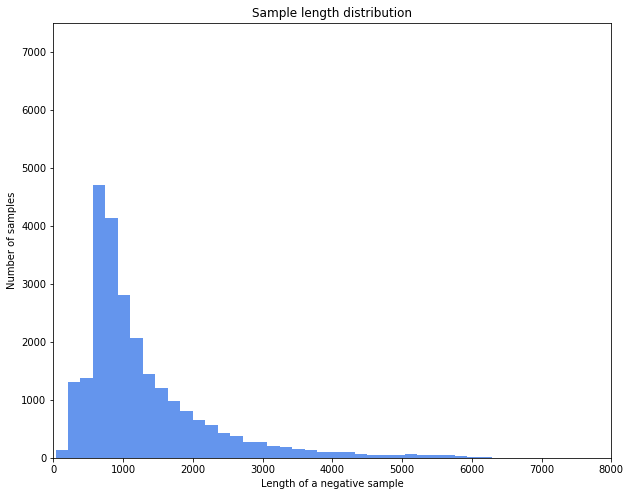

In [ ]:
# Checking the distribution of negative reviews
def plot_sample_length_distribution(sample_texts):
    """
    Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.

    # Returns
        Plots the length i.e. how many characters each sample has

    # Source: https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
    """
    
    plt.rcParams["figure.figsize"] = (10.0, 8.0)
    plt.hist([len(s) for s in sample_texts], 50, color = 'cornflowerblue')
    plt.xlabel('Length of a negative sample')
    plt.ylabel('Number of samples')
    plt.xlim(0, 8000)
    plt.ylim(0, 7500)
    plt.title('Sample length distribution')
    plt.show()
  
plot_sample_length_distribution(neg)

Let us visualize the reviews as well.

In [ ]:
# Code adapted from: 
# https://www.enjoyalgorithms.com/blog/sentiment-analysis-using-machine-learning
# Uncomment to produce an interactive plot else go to "Sentiment Visualization.html"
# file.

"""!pip install scattertext
import scattertext as st
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

di = {1: "Positive", 0: "Negative"}
parsed = df.assign(parse = lambda df: df.Text.apply(st.whitespace_nlp_with_sentences))
parsed = parsed.replace({"Label": di})
corpus = st.CorpusFromParsedDocuments(parsed.iloc[:2000, :], 
                                      category_col = 'Label', 
                                      parsed_col = 'parse').build()
html = st.produce_scattertext_explorer(corpus,
                                       category = "Positive",
                                       category_name = "Positive",
                                       not_category_name = "Negative",
                                       minimum_term_frequency = 5,
                                       width_in_pixels = 1000, 
                                       transform = st.Scalers.log_scale_standardize)
file_name = 'Sentiment Visualization.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src = file_name, width = 1000, height = 700)"""
print("") # to avoid displaying the text in docstrings

## Text Pre-Processing

Before we move on to the choice of models to train, it is essential to pre-process our text for the presence of contractions, tags, special characters, stop words, lemmas and extra letters. Therefore, we will start by looking at some raw text to check which actions are necessary.

In [ ]:
df.loc[0:5, 'Text'].values

array(["Canadian director Vincenzo Natali took the art-house circuit by storm with the intriguing and astonishingly intelligent Cube, which is my personal favourite SF film of the 90s. It framed the basic conceit of a group of strangers trapped in a maze shaped like a giant cube, shot entirely on one set, and took this idea in fascinating directions. <br /><br />I've been eagerly awaiting Natali's follow-up, and although its taken five years for him to mount another project, I'm delighted to say it was worth the wait. Cypher is a fascinating exploration of one man's place in the world, and how through a completely logical chain of events, finds himself in a situation beyond his control.<br /><br />I don't want to reveal too much about the plot, because one of the joys of Cypher is the different avenues it takes us down. It is so refreshing in this day and age to see a SF film that has more than one idea in it's head. Cypher is such a film.<br /><br />Morgan Sullivan (Jeremy Northam), o

- Expanding Contractions ---> `it's -> it is`, `I\'ve -> I have`, `we've -> we have` 
- Removing Stop words: `the`, `it`, `a`, `and`
- Removing Extra letters: e.g. `fuuuuun`
- Removing Special characters: `\`, `</>`
- Strip HTML links
- Removing accented characters: `Muriël-> Muriel`
- Lemmatize text


In [ ]:
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
# Import packages
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
!pip install contractions
from contractions import contractions_dict
import unicodedata

     |████████████████████████████████| 321 kB 37.2 MB/s 
     |████████████████████████████████| 284 kB 72.2 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85450 sha256=01c0ac8bea06d73ca4793659dd1531bcc97a3ef58212f957c1a89e0caa887f3e
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
nlp = spacy.load('en', parse = False, tag = False, entity = False)
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no') # keep 'no, not' as they might be useful in this 
stopword_list.remove('not')# context

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Expand contractions
#a = df.Text.apply(lambda x: " ".join([contractions_dict[i] if i in contractions_dict else i for i in x.split()]))
#a = a.apply(lambda x: " ".join([contractions_dict[i.lower()] if i.lower() in contractions_dict else i for i in x.split()]))
#a = a.apply(lambda x: " ".join([contractions_dict[punc_remover(i)[0]] + punc_remover(i)[1] if punc_remover(i)[0] in contractions_dict else i for i in x.split()]))
#a[0]

def punc_remover(doc):
  return re.sub(r"(\.|\?|\!|\:|\;)", r" \1", doc).split()

def expand_contractions(doc):
  a = " ".join([contractions_dict[i] if i in contractions_dict else i for i in doc.split()])
  a = " ".join([contractions_dict[i.lower()] if i.lower() in contractions_dict else i for i in a.split()])
  a = " ".join([contractions_dict[punc_remover(i)[0]] + punc_remover(i)[1] if punc_remover(i)[0] in contractions_dict and len(punc_remover(i)) == 2 else i for i in a.split()])
  return a

#expand_contractions(df.Text[0])

In [ ]:
# Remove stop words
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def remove_stopwords(text, is_lower_case = False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text

In [ ]:
# Remove extra letters
def remove_extra_letters(text):
  text = re.sub(r'(.)\1{3,}', r'\1\1', text)
  return text

In [ ]:
# Remove special characters
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def remove_special_characters(text):
  text = re.sub('[^a-zA-z0-9\s]', '', text)
  return text

In [ ]:
# Remove links
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  stripped_text = soup.get_text()
  return stripped_text

In [ ]:
# Remove accented characters
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

In [ ]:
# Lemmatize text
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def lemmatize_text(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

In [ ]:
# Normalize text
# Source: https://github.com/Naveen1331/NLP---SENTIMENT-ANALYSIS-ON-IMDB-MOVIE-DATASET-/blob/main/Text%20Normalization%20Demo.ipynb
def normalize_corpus(corpus, 
                     html_stripping = True, 
                     contraction_expansion = True,
                     accented_char_removal = True, 
                     text_lower_case = True, 
                     text_lemmatization = True, 
                     special_char_removal = True, 
                     stopword_removal = True):
  normalized_corpus = []
  # normalize each document in the corpus
  for doc in corpus:
    #print(doc)
    # strip HTML
    if html_stripping:
      doc = strip_html_tags(doc)
      #print(doc)
      # remove accented characters
      if accented_char_removal:
        doc = remove_accented_chars(doc)
        #print(doc)
        # expand contractions    
        if contraction_expansion:
          doc = expand_contractions(doc)
          #print(doc)
          # lowercase the text    
          if text_lower_case:
            doc = doc.lower()
            # remove extra newlines
            doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            #print(doc)
            # lemmatize text
            if text_lemmatization:
              doc = lemmatize_text(doc)
              # remove special characters   
              #print(doc) 
              if special_char_removal:
                doc = remove_special_characters(doc)  
                # remove extra whitespace
                doc = re.sub(' +', ' ', doc)
                #print(doc)
                # remove stopwords
                if stopword_removal:
                  doc = remove_stopwords(doc, is_lower_case = text_lower_case)

    normalized_corpus.append(doc)
  return normalized_corpus

In [ ]:
# Try the function
normalize_corpus(df.Text.iloc[:10].to_list(),
  html_stripping = True, 
  contraction_expansion = True,
  accented_char_removal = True, 
  text_lower_case = True, 
  text_lemmatization = True, 
  special_char_removal = True, 
  stopword_removal = True)

['canadian director vincenzo natali take art house circuit storm intriguing astonishingly intelligent cube personal favourite sf film 90 frame basic conceit group stranger trap maze shape like giant cube shoot entirely one set take idea fascinating direction eagerly await natali follow although take five year mount another project delighted say worth wait cypher fascinating exploration one man place world completely logical chain event find situation beyond control not want reveal much plot one joy cypher different avenue take us refreshing day age see sf film one idea head cypher film morgan sullivan jeremy northam one bland people ever walk planet hire company digicorp send different part america record different seminar bewilderment unbelievably boring cover topic mundane shave cream cheese morgan wait one seminar run rita foster impeccably cast lucy liu definition ice maiden give brush something find irresistible not surprising consider dry marriage rita turn another one morgan sem

In [ ]:
# We're adding docstrings around this since it is taking a long time to execute
# (~38min with free plan on Google Colab)
"""# Normalize the reviews' text on the train set
normalized_train = normalize_corpus(train.Text.to_list(),
                                   html_stripping = True, 
                                   contraction_expansion = True,
                                   accented_char_removal = True, 
                                   text_lower_case = True, 
                                   text_lemmatization = True, 
                                   special_char_removal = True, 
                                   stopword_removal = True)

# Normalize the reviews' text on the validation set
normalized_validation = normalize_corpus(validation.Text.to_list(),
                                         html_stripping = True, 
                                         contraction_expansion = True,
                                         accented_char_removal = True, 
                                         text_lower_case = True, 
                                         text_lemmatization = True, 
                                         special_char_removal = True, 
                                         stopword_removal = True)

# Normalize the reviews' text on the test set
normalized_test = normalize_corpus(test.Text.to_list(),
                                   html_stripping = True, 
                                   contraction_expansion = True,
                                   accented_char_removal = True, 
                                   text_lower_case = True, 
                                   text_lemmatization = True, 
                                   special_char_removal = True, 
                                   stopword_removal = True)
pd.Series(normalized_test).to_csv('normalized_test.csv', index = False)"""
print("")

In [ ]:
# Converted normalized corpus to csv so it doesn't take a long time to process 
# Only needs to be called once
#pd.Series(normalized_train).to_csv('normalized_train.csv', index = False)
#pd.Series(normalized_validation).to_csv('normalized_validation.csv', index = False)
#pd.Series(normalized_test).to_csv('normalized_test.csv', index = False)

# ATTENTION: Make sure to upload the csv files found under Datasets folder to 
# the Google Colab session before running this code block, else it will return 
# an error.
normalized_train = pd.read_csv('normalized_train.csv').iloc[:,0].to_list()
normalized_validation = pd.read_csv('normalized_validation.csv').iloc[:,0].to_list()
normalized_test = pd.read_csv('normalized_test.csv').iloc[:,0].to_list()

## Methodology

We shall use Bag of Words (BoW) as features and compare which perform best time-wise before we continue with the application of models.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import time

# Use CountVectorizer
# Source: 
# https://developers.google.com/machine-learning/guides/text-classification/step-3#feature_selection
count_vect = CountVectorizer(max_features = 20000, # use the 20000 most frequent
                                                   # words as features
                             ngram_range = (1, 2), # unigrams + bigrams
                             min_df = 3, # remove all the words that appear in
                                         # less than 3 documents 
                             max_df = 0.6, # remove all the words that appear in
                                           # more than 60% of the documents
                             analyzer = 'word', # the feature should be made of 
                                                # word n-grams
                             token_pattern = r'\w{1,}'
                             )
tic = time.time()

# Fit Count Vectorizer 
train_count_vect = count_vect.fit_transform(normalized_train)
test_count_vect  = count_vect.transform(normalized_test)
print(f"Time for CountVectorizer: {time.time() - tic:.2f} s")  

Time for CountVectorizer: 12.99 s


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features = 20000, # use the 20000 most frequent
                                                   # words as features
                             ngram_range = (1, 2), # unigrams + bigrams
                             min_df = 3, # remove all the words that appear in
                                         # less than 3 documents 
                             max_df = 0.6, # remove all the words that appear in
                                           # more than 60% of the documents 
                             analyzer = 'word', # the feature should be made of 
                                                # word n-grams
                             token_pattern = r'\w{1,}')
tic = time.time()

# Fit TfidfVectorizer
train_tfidf_vect = tfidf_vect.fit_transform(normalized_train)
test_tfidf_vect  = tfidf_vect.transform(normalized_test)
print(f"Time for TfidfVectorizer: {time.time() - tic:.2f} s") 

Time for TfidfVectorizer: 13.07 s


We can see that the `CountVectorizer` takes slightly less time to run than `TfidfVectorizer`.

## Model Selection

The following models will be used

- Logistic Regression with `CountVectorizer` and `TfidfVectorizer`
- Naive Bayes' with `TfidfVectorizer` and `CountVectorizer`
- SVM with `CountVectorizer` and `TfidfVectorizer`
- $\text{BERT}_{base}$ uncased
- BiLSTM (on "BILSTM with Keras" Jupyter notebook)

### Logistic Regression with `CountVectorizer`

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss, classification_report

# Testing for different c-values : Inverse of regularization strength; 
# must be a positive float. Like in support vector machines, smaller values 
# specify stronger regularization.
for c in [0.001, 0.01, 0.05, 0.1, 1]:
  LR = LogisticRegression(C = c, max_iter = 1000)
  LR.fit(train_count_vect, train.Label.to_list())
  F1_LR = f1_score(test.Label.to_list(), 
                   LR.predict(test_count_vect))
  print(f"f1_score for C = {c}: {F1_LR:.3f}")

f1_score for C = 0.001: 0.854
f1_score for C = 0.01: 0.882
f1_score for C = 0.05: 0.886
f1_score for C = 0.1: 0.884
f1_score for C = 1: 0.871


We notice that the highest `f1-score` is obtained for `C = 0.05`. Let us also perform Grid Search to investigate the best parameters to use before performing Logistic Regression and log the time taken for fitting and predicting as well as, `logloss` and `f1-score`.

### Grid Search CV for Logistic Regression


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Specify the parameters
# Double underscore indicate to which estimator a parameter belongs
parameters = {'vectorize__max_df': (0.5, 1.0),
              'vectorize__ngram_range': ((1, 1), (1, 2)), 
              'tfidf__use_idf': (True, False),
              'LR__C':[1, 0.1], 
              #'berNB__alpha':[1, 0.1]
              }

# Create the pipeline
pipe = Pipeline([('vectorize', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('LR', LogisticRegression()), 
                 #('berNB', BernoulliNB())
                ])

# Specify multiclass f1 score
my_scorer = make_scorer(f1_score, greater_is_better = True, average = 'macro')

# Specify the values to consider in the grid search
# Takes approximately 11 min to execute
grid_search = GridSearchCV(pipe, 
                           parameters, 
                           scoring = 'accuracy', 
                           cv = 5, 
                           n_jobs = -1)

# Fit the grid search on the balanced data
grid_search.fit(normalized_train, train['Label'].astype('int'))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorize', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR__C': [1, 0.1], 'tfidf__use_idf': (True, False),
                         'vectorize__max_df': (0.5, 1.0),
                         'vectorize__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [ ]:
print(f"The best parameters from the grid search are: {grid_search.best_params_} " + 
      f"\nwith best score of {grid_search.best_score_:.3f}.")

y_hat_opt = grid_search.predict(normalized_test)
print("Classification Report")
print(classification_report(test["Label"].astype('int'), 
                            y_hat_opt, 
                            target_names = ['negative', 'positive']))

The best parameters from the grid search are: {'LR__C': 1, 'tfidf__use_idf': True, 'vectorize__max_df': 1.0, 'vectorize__ngram_range': (1, 1)} 
with best score of 0.885.
Classification Report
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88     12500
    positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### Logistic Regression with `Count Vectorizer` (after performing Grid Search)

In [ ]:
# Start logging time
tic = time.time()
# Fit Logistic regression
LR = LogisticRegression(C = 1, max_iter = 2000)
LR.fit(train_count_vect, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = LR.predict(test_count_vect)
print(f"Predictions took... {time.time() - tic:.2f} s")  

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_LR = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_LR:.2f}")

# Classification report for Logistic Regression
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 7.58 s
Predictions took... 0.02 s
Logistic loss: 0.44
F1-score: 0.87
Classification Report
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87     12500
    positive       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



### Logistic Regression with `TfidfVectorizer`

In [ ]:
# Testing Logistic Regression with best parameters given from GridSearchCV

from sklearn.linear_model import LogisticRegression

# Start logging time
tic = time.time()
# Fit Logistic regression
LR = LogisticRegression(C = 1, max_iter = 1000)
LR.fit(train_tfidf_vect, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = LR.predict(test_tfidf_vect)
print(f"Predictions took... {time.time() - tic:.2f} s")  

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_LR = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_LR:.2f}")

# Classification report for Logistic Regression
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 0.98 s
Predictions took... 0.01 s
Logistic loss: 0.38
F1-score: 0.89
Classification Report
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89     12500
    positive       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



Indeed, we can see there is an improvement in time of execution using the parameters suggested by Grid Search.

Let us find the 20 most contributing words to positive review ranking.

In [ ]:
# Store the coefficients in a dictionary for nicer print out
feat2coef = {word: coefficient for word,
                coefficient in zip(tfidf_vect.get_feature_names_out(), 
                                   LR.coef_[0])}

print("20 most important words for positive reviews:")   
sorted(feat2coef.items(), key = lambda x: x[1], reverse = True)[:20]

20 most important words for positive reviews:


[('great', 6.342272907885837),
 ('excellent', 5.271613010275886),
 ('perfect', 4.549220511438766),
 ('love', 4.443128009659041),
 ('enjoy', 4.158831779506522),
 ('good', 4.1138468741117835),
 ('wonderful', 4.049657140111142),
 ('favorite', 3.7617246471248547),
 ('amazing', 3.7395767478858835),
 ('fun', 3.449936054581138),
 ('today', 3.159625773252015),
 ('brilliant', 3.06392469511408),
 ('life', 2.937702222726273),
 ('beautiful', 2.851423205587785),
 ('710', 2.849991843600578),
 ('definitely', 2.8207004717513438),
 ('superb', 2.810526201950506),
 ('highly', 2.765220715204504),
 ('fantastic', 2.6358818643301234),
 ('enjoyable', 2.6221186898596462)]

From the top 20 results, we can see that the model did a good job at classifying the most contributing words to positive review classification. Some results might be unintuitive in terms of interpretation, i.e. 710. A possible explanation is that this number corresponds to ratings, meaning that users have classified a certain movie with 7/10 stars, for instance.

Let us do the same to see which were the top 20 most important words to negative review ranking.

In [ ]:
print("20 most important words for negative reviews:")   
sorted(feat2coef.items(), key = lambda x: x[1])[:20]

20 most important words for negative reviews:


[('bad', -9.885211470959897),
 ('waste', -5.881481603007913),
 ('awful', -5.616357872127562),
 ('boring', -4.732212502123369),
 ('poor', -4.439706967634828),
 ('no', -4.3960832733292925),
 ('nothing', -4.2162340098539515),
 ('terrible', -4.15350268374261),
 ('fail', -3.961926648243185),
 ('dull', -3.741251478626966),
 ('stupid', -3.69526504970126),
 ('suppose', -3.6485488109455657),
 ('save', -3.6228983606369507),
 ('horrible', -3.5577024936110115),
 ('lack', -3.546555278010567),
 ('unfortunately', -3.4375163272668505),
 ('poorly', -3.4302670481556707),
 ('script', -3.2213799424219656),
 ('not even', -3.215080595995132),
 ('lame', -3.182138629728173)]

Indeed, the displayed results correspond to a negative sentiment. 

### Naive Bayes' with `TfidfVectorizer`

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# Start logging time
tic = time.time()
# Fit Naive Bayes' Classifier for binary/boolean features
NB = BernoulliNB(alpha = 1) # default
NB.fit(train_tfidf_vect, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = NB.predict(test_tfidf_vect)
print(f"Predictions took... {time.time() - tic:.2f} s")

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_NB = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_NB:.2f}")

# Classification report for Naive Bayes
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 0.05 s
Predictions took... 0.05 s
Logistic loss: 0.47
F1-score: 0.86
Classification Report
              precision    recall  f1-score   support

    negative       0.86      0.87      0.87     12500
    positive       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



### Naive Bayes with `CountVectorizer`

In [ ]:
from sklearn.naive_bayes import BernoulliNB

# Start logging time
tic = time.time()
# Fit Naive Bayes' Classifier for binary/boolean features
NB = BernoulliNB(alpha = 1) # default
NB.fit(train_count_vect, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = NB.predict(test_count_vect)
print(f"Predictions took... {time.time() - tic:.2f} s")

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_NB = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_NB:.2f}")

# Classification report for Naive Bayes
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 0.04 s
Predictions took... 0.04 s
Logistic loss: 0.47
F1-score: 0.86
Classification Report
              precision    recall  f1-score   support

    negative       0.86      0.87      0.87     12500
    positive       0.87      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



### SVM with `CountVectorizer`

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.svm import SVC

# Cell takes approximately 2.5min to execute in Google Colab Pro

# Use SVD to reduce dimensionality 
# We found that 100-200 components usually suffice
SVD = TruncatedSVD(n_components = 100)
SVD_train = SVD.fit_transform(train_count_vect)
SVD_test = SVD.transform(test_count_vect)

# Scale the data 
sdScaler = preprocessing.StandardScaler()
SVD_train_scaled = sdScaler.fit_transform(SVD_train)
SVD_test_scaled = sdScaler.transform(SVD_test)

# Start logging time
tic = time.time()
# Fit SVM
SVM = SVC(C = 1.0, probability = True)
SVM.fit(SVD_train_scaled, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = SVM.predict(SVD_test_scaled)
pred = np.where(pred == -1, 0, pred)
print(f"Predictions took... {time.time() - tic:.2f} s") 

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_SVM = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_SVM:.2f}")

# Classification report for SVM
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 146.13 s
Predictions took... 28.78 s
Logistic loss: 0.66
F1-score: 0.81
Classification Report
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81     12500
    positive       0.80      0.82      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



### SVM with `TfidfVectorizer`

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.svm import SVC

# Cell takes approximately 2min to execute in Google Colab Pro

# Use SVD 
# We found that 100-200 components usually suffice
SVD = TruncatedSVD(n_components = 100)
SVD_train = SVD.fit_transform(train_tfidf_vect)
SVD_test = SVD.transform(test_tfidf_vect)

# Scale the data 
sdScaler = preprocessing.StandardScaler()
SVD_train_scaled = sdScaler.fit_transform(SVD_train)
SVD_test_scaled = sdScaler.transform(SVD_test)

# Start logging time
tic = time.time()
# Fit SVM
SVM = SVC(C = 1.0, probability = True)
SVM.fit(SVD_train_scaled, train.Label.to_list())
print(f"Training took... {time.time() - tic:.2f} s") 

# Start logging time
tic = time.time()
# Make predictions
pred = SVM.predict(SVD_test_scaled)
pred = np.where(pred == -1, 0, pred)
print(f"Predictions took... {time.time() - tic:.2f} s") 

# Calculate logloss and f1-score
Log_loss = log_loss(test.Label.to_list(), pred) * 0.1
print(f"Logistic loss: {Log_loss:.2f}")
F1_SVM = f1_score(test.Label.to_list(), pred)
print(f"F1-score: {F1_SVM:.2f}")

# Classification report for SVM
print("Classification Report")
print(classification_report(test.Label.to_list(), 
                            pred, 
                            target_names = ['negative', 'positive']))

Training took... 124.00 s
Predictions took... 23.94 s
Logistic loss: 0.49
F1-score: 0.86
Classification Report
              precision    recall  f1-score   support

    negative       0.86      0.86      0.86     12500
    positive       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



## $\text{BERT}_{base}$ uncased

In [ ]:
# Install the necessary packages
!pip install transformers

     |████████████████████████████████| 3.4 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 3.3 MB 45.6 MB/s 
     |████████████████████████████████| 61 kB 509 kB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


After the installation is completed, we shall load the pre-trained BERT Tokenizer and Sequence Classifier as well as `InputExample` and `InputFeatures`. Then we will build our model with the Sequence Classifier and the tokenizer with BERT's tokenizer.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

# Load BERT uncased model + tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels = 2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# See the summary
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


👉 After quick inspection, we can see that we have a simple model architecture that includes the main BERT model, a Dropout layer to prevent overfitting and a Dense layer for the classification task. 

Now we will create the main Input Sequences from the IMDb data set.

We already have the train and test data sets as pandas dataframe objects so we will create two helper functions.

- `convert_data_to_examples`: This function takes the train and test datasets and converts each row into an `InputExample` object.

- `convert_examples_to_tf_dataset`: This function performs tokenization of the `InputExample` objects and outputs the required input format with the tokenized objects into an input dataset that we can be fed to the model.

In [ ]:
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
def convert_data_to_examples(train, validation, Text, Label):
  train_InputExamples = train.apply(lambda x: InputExample(guid = None, # Globally unique ID for bookkeeping, unused in this case
                                                           text_a = x[Text], # the text we want to classify, 
                                                                             # which in this case, is the Request 
                                                                             # field in our dataframe
                                                           text_b = None, # used if we're training a model to understand 
                                                                          # the relationship between sentences
                                                           label = x[Label]), 
                                                           axis = 1)

  validation_InputExamples = validation.apply(lambda x: InputExample(guid = None, # Globally unique ID for bookkeeping, unused in this case
                                                                     text_a = x[Text], 
                                                                     text_b = None,
                                                                     label = x[Label]), 
                                                                     axis = 1)
  
  return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                         validation, 
                                                                         'Text', 
                                                                         'Label')

# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length = 128):
  features = [] # will hold InputFeatures to be converted later
  for e in examples:
    input_dict = tokenizer.encode_plus(e.text_a,
                                       add_special_tokens = True,
                                       max_length = max_length, # truncates if len(s) > max_length
                                       return_token_type_ids = True,
                                       return_attention_mask = True,
                                       pad_to_max_length = True, # pads to the right by default 
                                       truncation = True)
    input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                 input_dict["token_type_ids"], 
                                                 input_dict['attention_mask'])
    features.append(InputFeatures(input_ids = input_ids, # converts each sentence into a set of token ids
                                  attention_mask = attention_mask, # Since we are padding all the sequences 
                                                                   # to 128(max sequence length), it is important that 
                                                                   # we create some sort of mask to make sure those paddings 
                                                                   # do not interfere with the actual text tokens. 
                                                                   # Therefore we need a generate input mask blocking the paddings. 
                                                                   # The mask has 1 for real tokens and 0 for padding tokens. 
                                                                   # Only real tokens are attended to.
                                  token_type_ids = token_type_ids, # Indices of input sequence tokens in the vocabulary (since
                                                                   # there is only one sequence, the token_type_ids is essentially 
                                                                   # just a vector of 0s
                                                                   # Sources: 
                                                                   # https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
                                                                   # https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification
                                  label = e.label))

  def gen():
    for f in features:
      yield (
          {
                 "input_ids": f.input_ids,
                 "attention_mask": f.attention_mask,
                 "token_type_ids": f.token_type_ids,
          },
          f.label,
     )

  return tf.data.Dataset.from_generator(gen, 
                                        ({"input_ids": tf.int32, 
                                          "attention_mask": tf.int32, 
                                          "token_type_ids": tf.int32}, 
                                         tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

Text = 'Text'
Label = 'Label'

In [ ]:
# Call the functions (takes approximately 2.5 min to execute)
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                         validation, 
                                                                         Text, 
                                                                         Label)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(1000).batch(32).repeat(5)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), 
                                                 tokenizer)
validation_data = validation_data.batch(32)

Now we are ready to feed our data set to the BERT model. We will use `'Adam'` as our optimizer, `'SparseCategoricalCrossentropy'` as our loss function, and `'SparseCategoricalAccuracy'` as our accuracy metric. 

Sources:

👉 https://developers.google.com/machine-learning/guides/text-classification/step-4

👉 https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy

In [ ]:
# Model takes 1h to be fitted without Colab Pro (20' with Pro mode) 
BERT = model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5,
                                                          epsilon = 1e-08, 
                                                          clipnorm = 1.0), 
                     # from_logits: Whether y_pred is expected to be a logits 
                     # tensor
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                     metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = model.fit(train_data, 
                    epochs = 2, 
                    validation_data = validation_data, 
                    steps_per_epoch = 1000)

Epoch 1/2
1000/1000 [==============================] - 542s 516ms/step - loss: 0.2975 - accuracy: 0.8707 - val_loss: 0.3418 - val_accuracy: 0.8728
Epoch 2/2
1000/1000 [==============================] - 513s 513ms/step - loss: 0.1102 - accuracy: 0.9591 - val_loss: 0.4470 - val_accuracy: 0.8748


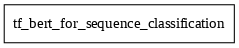

In [ ]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76, expand_nested = True)

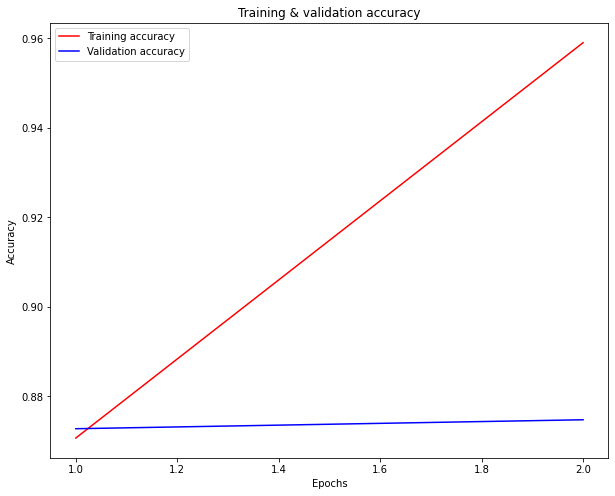

In [ ]:
# Get metrics 
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training + validation accuracy
plt.plot(epochs, acc, '-r', label = 'Training accuracy')
plt.plot(epochs, val_acc, '-b', label = 'Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Evaluate the model
print('Validation loss: %.4f' % val_loss[1])
print('Validation accuracy: %.4f' % val_acc[1])

Validation loss: 0.4470
Validation accuracy: 0.8748


Let's try to make some predictions to test our BERT model.

We need to tokenize our reviews with our pre-trained BERT tokenizer. We will then feed these tokenized sequences to our model and run a final softmax layer to get the predictions. We can then use the `argmax` function to determine whether our sentiment prediction for the review is positive or negative. Finally, we will print out a classification report and the predictions for the first 10 sentences of the test dataset with a for loop. 

In [ ]:
# Predicting sentiment for the test document with the BERT model
# Inspired by: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

test["BERT"] = np.nan
for idx in range(0, 25000, 10):
    tf_batch = tokenizer(normalized_test[idx:idx+10], 
                        max_length = 256, 
                        padding = True, 
                        truncation = True, 
                        return_tensors = 'tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis = -1)
    label = tf.argmax(tf_predictions, axis = 1)
    label = label.numpy()
    test.loc[idx:idx+10-1, "BERT"] = label

In [ ]:
print("Classification Report")
print(classification_report(test.Label.to_list(), test.BERT.astype('int32').to_list()))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.95      0.86     12500
           1       0.94      0.73      0.82     12500

    accuracy                           0.84     25000
   macro avg       0.86      0.84      0.84     25000
weighted avg       0.86      0.84      0.84     25000



In [ ]:
labels = ['Negative', 'Positive']

for doc in test[:10].itertuples():
  print(f"Review {doc.Index+1}: {doc.Text} :\nSentiment: {labels[int(doc.BERT)]}")

Review 1: A lovely librarian, played by Playboy model Kristine DeBell, falls asleep and dreams herself into a strange world filled with extremely uninhibited people These people love to sing and dance and fool around Alice has a series of sensual adventures among these characters <br /><br />The film was originally shot as a poem to eroticism with few explicit sex scenes, which were eventually cut from its theatrical release Videocassette versions, however, have had some of the original erotic encounters joined at the end with them <br /><br />For an extremely low-budget picture, the producers of this film did an extremely good job The cinematography is full of life and energy, the dances and numbers quite professional, and the acting lovable Without a doubt, it is one of the best adult fairy tales around :
Sentiment: Positive
Review 2: I suffered the watching of this movie at Sitges Festival last month. If there would be a possibility of "unfilm" a movie to avoid its existence